# Yankees - Propensity Event- NextTierBuyer
* StelllarAlgo Data Science
* Ryan Kazmerik & Nakisa Rad
* Feb 03, 2022

## Hypothesis


## Experiment
This section details our experiment including querying data, data transformations, feature selection and modelling.

In [1]:
import getpass
import pyodbc
import pandas as pd
import warnings
import matplotlib.pyplot as plt

from pycaret.classification import *

warnings.filterwarnings('ignore')

### Let's connect to MSSQL and run a stored proc to get our dataset:

In [2]:
# connect to SQL Server.
SERVER = '54.164.224.129'  
DATABASE = 'stlrRays' 
USERNAME = 'nrad' 
PASSWORD = 'Y34@PSc^n@JAG=4%p8194'#getpass.getpass(prompt='Enter your password')
CNXN = pyodbc.connect('DRIVER={ODBC Driver 17 for SQL Server};SERVER='+SERVER+';DATABASE='+DATABASE+';UID='+USERNAME+';PWD='+ PASSWORD)

In [3]:
lkupclientid = 53 # Yankees

cursor = CNXN.cursor()

storedProc = (
    f"""Exec [stlrYankees].[ds].[getPropensityEventScoring_new] {lkupclientid}"""
)

df = pd.read_sql(storedProc, CNXN)

# apply some data transformations
df["year"] = pd.to_numeric(df["year"]) 

CNXN.commit()
cursor.close()

df.shape

DatabaseError: Execution failed on sql 'Exec [stlrYankees].[ds].[getPropensityEventScoring_new] 53': ('42000', "[42000] [Microsoft][ODBC Driver 17 for SQL Server][SQL Server]Could not find stored procedure 'stlrYankees.ds.getPropensityEventScoring_new'. (2812) (SQLExecDirectW)")

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 522560 entries, 0 to 522559
Data columns (total 32 columns):
 #   Column                      Non-Null Count   Dtype         
---  ------                      --------------   -----         
 0   lkupClientId                522560 non-null  int64         
 1   dimCustomerMasterId         522560 non-null  int64         
 2   eventName                   522560 non-null  object        
 3   inMarket                    522560 non-null  int64         
 4   year                        522560 non-null  int64         
 5   productGrouping             522560 non-null  object        
 6   Tier                        522560 non-null  int64         
 7   eventDay                    522560 non-null  int64         
 8   totalSpent                  522560 non-null  float64       
 9   recentDate                  522560 non-null  datetime64[ns]
 10  attendancePercent           522560 non-null  float64       
 11  renewedBeforeDays           522560 non-

In [49]:
df.shape

(522560, 32)

In [50]:
df.to_csv('yankees-data-export.csv')

### We should specify the features used in our model:

In [19]:
# choose the features for the stellar base retention model
features = ["dimCustomerMasterId",
        "attendancePercent",
        "click_link",
        "clickToSendRatio",
        "clickToOpenRatio",
        "distToVenue",
        "fill_out_form",
        "inMarket",
        "open_email" ,
        "openToSendRatio",
        "recency",
        "renewedBeforeDays",
        "send_email",
        "source_tenure",
        "tenure",
        "totalGames",
        "unsubscribe_email",
        "nextYearTier",
        "year"
]

# copy your main dataframe
df_dataset = df

# choose the features & train year & test year
df_dataset = df_dataset[features]
df_dataset["year"] = pd.to_numeric(df_dataset["year"])
df_dataset = df_dataset.loc[df_dataset["year"] <= 2019]
#df_dataset = df_dataset[df_dataset["Tier"] == {1,2,3} ]

df_train = df_dataset.sample(frac=0.85, random_state=786)
df_eval = df_dataset.drop(df_train.index)

df_train.reset_index(drop=True, inplace=True)
df_eval.reset_index(drop=True, inplace=True)

# print out the number of records for training and eval
print('Data for Modeling: ' + str(df_train.shape))
print('Unseen Data For Predictions: ' + str(df_eval.shape), end="\n\n")

Data for Modeling: (372955, 18)
Unseen Data For Predictions: (65816, 18)



### Now we can model the data using a binary classification prediction for the isnextyear_buyer field to see how likely a customer is to re-purchase.

In [20]:
setup(
    data= df_train, 
    target="nextYearTier", 
    train_size = 0.80,
    data_split_shuffle=True,
    ignore_features=["dimCustomerMasterId","year"],
    silent=True,
    verbose=False,
    numeric_features=[
        "attendancePercent",
        "renewedBeforeDays",
        "source_tenure",
        "tenure",
        "distToVenue",
        "totalGames",
        "recency",
        "click_link",
        "fill_out_form",
        "open_email" ,
        "send_email",
        "unsubscribe_email",
        "openToSendRatio",
        "clickToSendRatio",
        "clickToOpenRatio"
    ]
);

In [21]:
model_matrix = compare_models(
    fold=10,
    include=["xgboost"]
)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
xgboost,Extreme Gradient Boosting,0.8208,0.8838,0.3295,0.8059,0.7796,0.3903,0.4322,44.1660


In [ ]:
best_model = create_model(model_matrix)
final_model = finalize_model(best_model)

### Let's load in our 2022 season data and get retention scores using the model:

In [27]:
df_inference = df.loc[df["year"] >= 2021]
df_inference = df_inference.fillna(0)
df_inference.shape

(83789, 32)

In [28]:
df_inference

,lkupClientId,dimCustomerMasterId,eventName,inMarket,year,productGrouping,Tier,eventDay,totalSpent,recentDate,...,unsubscribe_email,openToSendRatio,clickToSendRatio,clickToOpenRatio,numWebEngagementActivities,numAppViewsActivities,credits_after_refund,NumberofGamesPerSeason,isNextGameBuyer,nextYearTier
438771,53,51,20210527 - Toronto Blue Jays,1,2021,Online Individual Game,5,4,32.0,1970-01-01,...,9,0.400000,0.000000,0.000000,0.0,0.0,0.0,94,0,0
438772,53,76,20210401 - Toronto Blue Jays,1,2021,Online Individual Game,1,4,900.0,1970-01-01,...,0,0.282178,0.024752,0.087719,0.0,0.0,0.0,94,1,0
438773,53,360,20210817 - Boston Red Sox,1,2021,Online Individual Game,2,2,150.0,1970-01-01,...,0,0.641711,0.000000,0.000000,0.0,0.0,0.0,94,0,0
438774,53,360,20210903 - Baltimore Orioles,1,2021,Online Individual Game,5,5,0.0,1970-01-01,...,0,0.641711,0.000000,0.000000,0.0,0.0,0.0,94,0,0
438775,53,590,20210819 - Minnesota Twins,1,2021,Online Individual Game,7,4,122.0,1970-01-01,...,0,0.131579,0.000000,0.000000,0.0,0.0,0.0,94,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
522555,53,24882324,20210818 - Boston Red Sox,1,2021,Online Individual Game,3,3,30.0,2021-08-18,...,0,0.635220,0.031447,0.049505,1035.0,18.0,0.0,94,0,0
522556,53,24882486,20210906 - Toronto Blue Jays,1,2021,Online Individual Game,6,1,310.0,1970-01-01,...,0,1.011765,0.023529,0.023256,0.0,0.0,0.0,94,0,0
522557,53,24882495,20210805 - Seatle Mariners,1,2021,Online Individual Game,6,4,0.0,1970-01-01,...,0,0.215789,0.000000,0.000000,0.0,0.0,0.0,94,0,0
522558,53,24882495,20210817 - Boston Red Sox,1,2021,Online Individual Game,2,2,0.0,1970-01-01,...,0,0.215789,0.000000,0.000000,0.0,0.0,0.0,94,0,0


In [29]:
new_predictions = predict_model(final_model, data=df_inference, raw_score=True)
new_predictions.head()

,lkupClientId,dimCustomerMasterId,eventName,inMarket,year,productGrouping,Tier,eventDay,totalSpent,recentDate,...,NumberofGamesPerSeason,isNextGameBuyer,nextYearTier,Label,Score_0,Score_1,Score_2,Score_3,Score_4,Score_5
438771,53,51,20210527 - Toronto Blue Jays,1,2021,Online Individual Game,5,4,32.0,1970-01-01,...,94,0,0,0,0.9913,0.0014,0.0021,0.0016,0.0021,0.0014
438772,53,76,20210401 - Toronto Blue Jays,1,2021,Online Individual Game,1,4,900.0,1970-01-01,...,94,1,0,0,0.9997,0.0002,0.0000,0.0000,0.0000,0.0000
438773,53,360,20210817 - Boston Red Sox,1,2021,Online Individual Game,2,2,150.0,1970-01-01,...,94,0,0,0,0.5014,0.0028,0.2108,0.1533,0.1126,0.0190
438774,53,360,20210903 - Baltimore Orioles,1,2021,Online Individual Game,5,5,0.0,1970-01-01,...,94,0,0,0,0.5620,0.0158,0.2258,0.1387,0.0401,0.0176
438775,53,590,20210819 - Minnesota Twins,1,2021,Online Individual Game,7,4,122.0,1970-01-01,...,94,0,0,0,0.9998,0.0001,0.0000,0.0000,0.0000,0.0000


In [30]:
new_predictions["Label"].value_counts()

0    83263
4      375
2       71
3       61
1       10
5        9
Name: Label, dtype: int64

In [31]:
new_predictions["Score_1"].value_counts(bins=[0, 0.2, 0.4, 0.6, 0.8, 1.0])

(-0.001, 0.2]    83760
(0.2, 0.4]          23
(0.4, 0.6]           4
(0.6, 0.8]           2
(0.8, 1.0]           0
Name: Score_1, dtype: int64

In [32]:
new_predictions["Score_2"].value_counts(bins=[0, 0.2, 0.4, 0.6, 0.8, 1.0])

(-0.001, 0.2]    83351
(0.2, 0.4]         389
(0.4, 0.6]          39
(0.6, 0.8]          10
(0.8, 1.0]           0
Name: Score_2, dtype: int64

In [33]:
new_predictions["Score_3"].value_counts(bins=[0, 0.2, 0.4, 0.6, 0.8, 1.0])

(-0.001, 0.2]    83471
(0.2, 0.4]         265
(0.4, 0.6]          49
(0.6, 0.8]           4
(0.8, 1.0]           0
Name: Score_3, dtype: int64

In [34]:
new_predictions["Score_4"].value_counts(bins=[0, 0.2, 0.4, 0.6, 0.8, 1.0])

(-0.001, 0.2]    82841
(0.2, 0.4]         558
(0.4, 0.6]         197
(0.6, 0.8]         112
(0.8, 1.0]          81
Name: Score_4, dtype: int64

In [35]:
new_predictions["Score_5"].value_counts(bins=[0, 0.2, 0.4, 0.6, 0.8, 1.0])

(-0.001, 0.2]    83737
(0.2, 0.4]          50
(0.4, 0.6]           2
(0.6, 0.8]           0
(0.8, 1.0]           0
Name: Score_5, dtype: int64

array([[<AxesSubplot:title={'center':'Score_1'}>]], dtype=object)

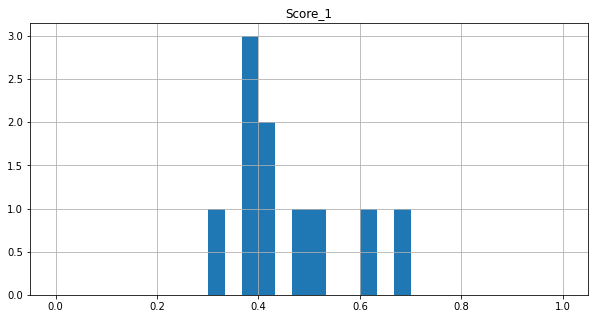

In [38]:
new_predictions[new_predictions["Label"]==1][["Score_1"]].hist(bins=30, figsize=(10,5), range=[0,1])

array([[<AxesSubplot:title={'center':'Score_2'}>]], dtype=object)

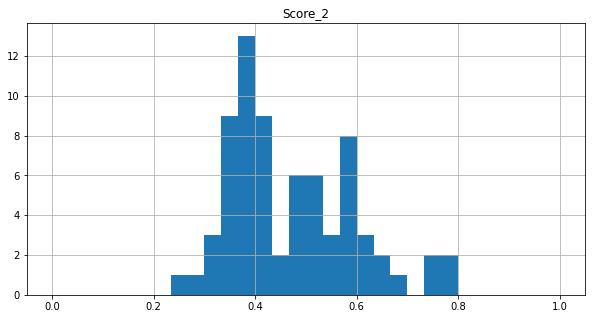

In [39]:
new_predictions[new_predictions["Label"]==2][["Score_2"]].hist(bins=30, figsize=(10,5), range=[0,1])

array([[<AxesSubplot:title={'center':'Score_3'}>]], dtype=object)

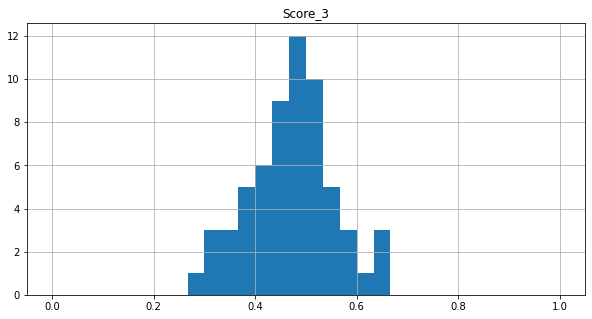

In [40]:
new_predictions[new_predictions["Label"]==3][["Score_3"]].hist(bins=30, figsize=(10,5), range=[0,1])

array([[<AxesSubplot:title={'center':'Score_4'}>]], dtype=object)

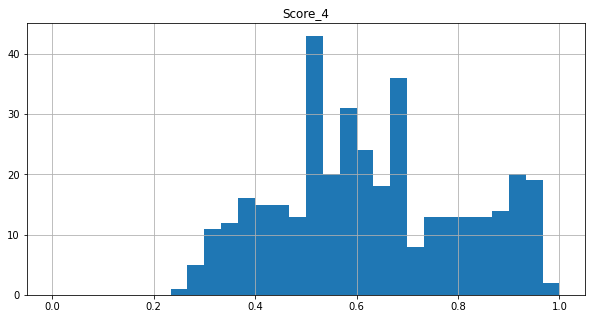

In [41]:
new_predictions[new_predictions["Label"]==4][["Score_4"]].hist(bins=30, figsize=(10,5), range=[0,1])

array([[<AxesSubplot:title={'center':'Score_5'}>]], dtype=object)

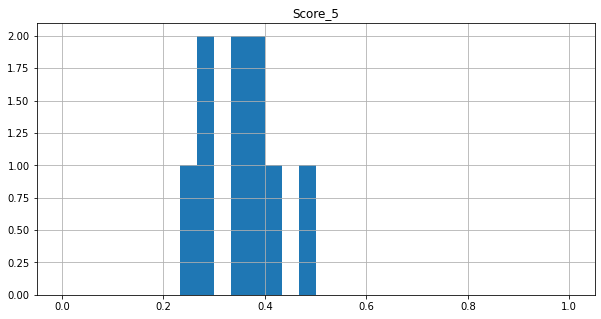

In [42]:
new_predictions[new_predictions["Label"]==5][["Score_5"]].hist(bins=30, figsize=(10,5), range=[0,1])

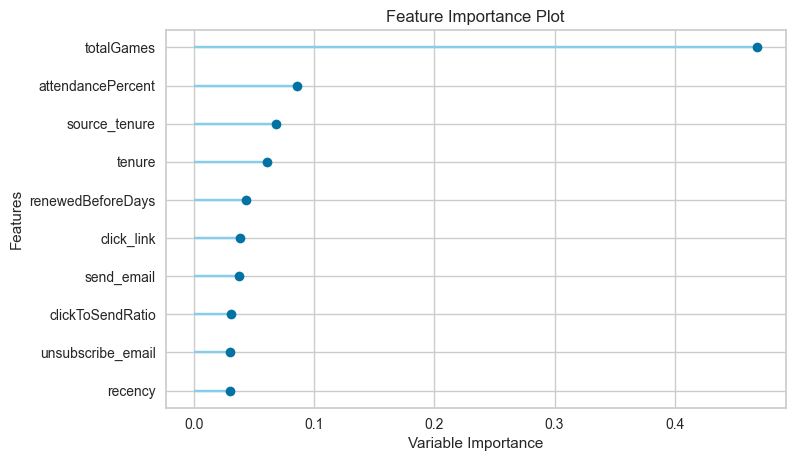

In [45]:
plot_model(best_model, plot='feature')

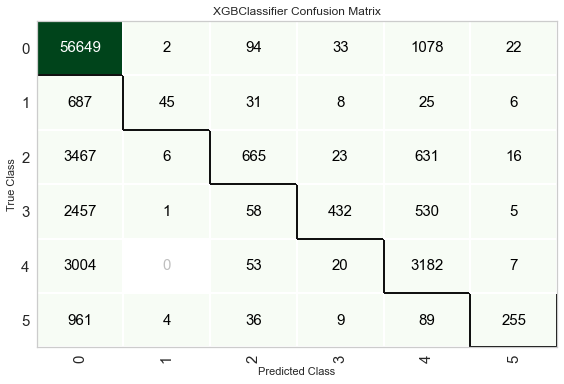

In [46]:
plot_model(best_model, plot='confusion_matrix')

## Observations
Here you can document some ideas on the results from above


## Conclusions
Here you can talk about next steps, did the experiment work? If yes, what to do next? If no, why?

* We should ask CS/CI what they think the most significant factor towards a next game buyer is.